In [2]:
from google.colab import drive



drive.mount('/gdrive')

%cd /gdrive/My Drive/Colab Notebooks/AN2DL/ShareFolder/Preprocessing

#directory of my folder in google drive

Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).
/gdrive/My Drive/Colab Notebooks/AN2DL/ShareFolder/Preprocessing


In [3]:
seed = 85 # random variable to make the code reproducible



# Import necessary libraries

import os



# Set environment variables before importing modules

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

os.environ['PYTHONHASHSEED'] = str(seed)

os.environ['MPLCONFIGDIR'] = os.getcwd() + '/configs/'



# Suppress warnings

import warnings

warnings.simplefilter(action='ignore', category=FutureWarning)

warnings.simplefilter(action='ignore', category=Warning)



# Import necessary modules

import numpy as np

import hashlib

import logging

import random



# Set seeds for random number generators in NumPy and Python

np.random.seed(seed)

random.seed(seed)



# Import TensorFlow and Keras

import tensorflow as tf

from tensorflow import keras as tfk

from tensorflow.keras import layers as tfkl



# Set seed for TensorFlow

tf.random.set_seed(seed)

tf.compat.v1.set_random_seed(seed)



# Reduce TensorFlow verbosity

tf.autograph.set_verbosity(0)

tf.get_logger().setLevel(logging.ERROR)

tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)



# Print TensorFlow version

print(tf.__version__)



# Import other libraries

import matplotlib.pyplot as plt

import pandas as pd

from sklearn.model_selection import train_test_split

from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, f1_score

from sklearn.utils.class_weight import compute_class_weight

import seaborn as sns

from PIL import Image

import matplotlib.gridspec as gridspec



# Configure plot display settings

sns.set(font_scale=1.4)

sns.set_style('white')

plt.rc('font', size=14)

%matplotlib inline

2.17.1


In [4]:
data = np.load('training_set_cleaned.npz') # load the blood cells dataset into a variable called 'data'

print(data.files)

# as we can see in the previus output, the dataset is composed by two arrays: images and labels

['images', 'labels']


In [5]:
# Define a mapping of labels to their corresponding digit names

classes = {0:'Basophil', 1:'Eosinophil', 2:'Erythroblast', 3:'Immature granulocytes', 4:'Lymphocyte', 5:'Monocyte', 6:'Neutrophil', 7:'Platelet'} # 8 classes

# Save unique labels

unique_labels = list(classes.values())

In [6]:
# splitting between images and labels

X = data['images']

y = data['labels']

print(X.shape)

print(y.shape)

(11353, 96, 96, 3)
(11353, 1)


In [ ]:
print(X.min(), X.max())

0 255


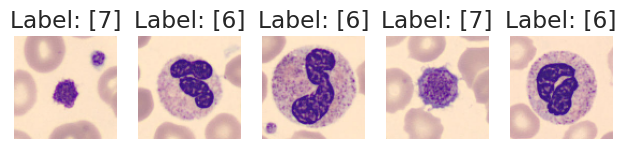

In [ ]:
for i in range(5):

    plt.subplot(1, 5, i + 1)  # Arrange plots in a single row

    plt.imshow(X[i])  # Display image, adjust cmap if images are in grayscale

    plt.title(f"Label: {y[i]}")

    plt.axis('off')  # Remove axes for better visibility



plt.tight_layout()

plt.show()

In [7]:
# keeping 80% for the training set and 20% for the validation

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)



print("Train:", X_train.shape, y_train.shape)

print("Validation:", X_val.shape, y_val.shape)

Train: (9082, 96, 96, 3) (9082, 1)
Validation: (2271, 96, 96, 3) (2271, 1)


In [8]:
# compute_class_weight

class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train.ravel())

class_weight_dict = dict(zip(np.unique(y_train), class_weights))

class_weight_dict

{0: 1.733206106870229,
 1: 0.6741389548693587,
 2: 1.3827649208282582,
 3: 0.8214544138929089,
 4: 1.6918777943368106,
 5: 1.5403663500678426,
 6: 0.6227372462973121,
 7: 0.8672650878533231}

In [9]:
# Convert labels to categorical format using one-hot encoding

y_train = y_train.flatten()

y_val = y_val.flatten()

y_train

array([0, 6, 5, ..., 7, 1, 6], dtype=uint8)

In [10]:
input_shape = (96,96,3) # input shape our dataset

output_shape = len(np.unique(y_train)) # output shape: 8 classes

print("Input Shape:", input_shape)

print("Output Shape:", output_shape)



# it makes sense because the input shape is the dimension of the image and 3 channels

# and the output is 8 as the number of the possible classes

Input Shape: (96, 96, 3)
Output Shape: 8


In [11]:
epochs = 100 # epochs

batch_size = 64 # batch

learning_rate = 1e-4 # step size for updating the model's weights

In [12]:
augmentations = tf.keras.Sequential([
    tf.keras.layers.RandomRotation(0.3),  # Rotate by 20%
    tf.keras.layers.RandomFlip("horizontal_and_vertical"),  # Flip both ways
    tf.keras.layers.RandomZoom(0.1),  # Zoom in/out
    #tf.keras.layers.RandomTranslation(0.2, 0.2),  # Shift horizontally/vertically
    tf.keras.layers.RandomBrightness(0.2, value_range=(0,255)),  # Brightness adjustment
    #tf.keras.layers.RandomContrast(0.2),  # Contrast adjustment
    tf.keras.layers.GaussianNoise(0.2)
])

X_train_aug = augmentations(X_train)


In [20]:
from tensorflow.keras.applications import Xception

from tensorflow.keras.models import Model



# Initialise ResNet50 model with pretrained weights, for transfer learning

Xception = tfk.applications.Xception(

    include_top=False,

    weights="imagenet",

    input_shape=input_shape
)

In [24]:
from tensorflow.keras.applications import Xception
from tensorflow.keras.models import Model

from tensorflow.keras.layers import Dropout, Dense

from tensorflow.keras.applications.xception import preprocess_input

# RETE PRE ADDESTRATA
model = Xception(

    input_shape=(96,96,3),

    include_top=False, # in pratica sto togliendo il dense layer per risolvere un mio task enon la classificazione

    weights='imagenet',

    pooling = 'avg'

)


# Freeze all layers in InceptionV3 to use it solely as a feature extractor

model.trainable = False



# input layer

inputs = tfk.Input(shape=(96, 96, 3), name='input_layer')



#x = tf.keras.layers.Resizing(224, 224)(inputs)
#x = augmentations(inputs)

x = preprocess_input(inputs)

# Uso lo strato della rete

x = model(x)


# Strato denso finale per la classificazione (output)
x = tfkl.Dense(512, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.02),name="dense_1")(x)

x = tfkl.Dropout(0.5, name='dropout1')(x)

x = tfkl.Dense(256, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.02),name="dense_2")(x)

x = tfkl.Dropout(0.5, name='dropout2')(x)



outputs = tfkl.Dense(8, activation='softmax', name='denseo')(x)



# Create a Model connecting input and output

model = tfk.Model(inputs=inputs, outputs=outputs, name='model')



# Compile the model with Categorical Cross-Entropy loss and Adam optimizer

model.compile(loss=tfk.losses.SparseCategoricalCrossentropy(),

              optimizer=tfk.optimizers.Lion(learning_rate = learning_rate),

              metrics=['accuracy'])

# Display a summary of the model architecture
#model.summary(expand_nested=True)

In [25]:
# Train the model

history_stage1 = model.fit(

    x=X_train_aug,

    y=y_train,

    batch_size=batch_size,

    epochs=30,

    class_weight=class_weight_dict,

    validation_data=(X_val, y_val),

    callbacks=[
        tfk.callbacks.EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True),
    ]

).history



# Calculate and print the best validation accuracy achieved

final_val_accuracy = round(max(history_stage1['val_accuracy']) * 100, 2)

print(f'Final validation accuracy: {final_val_accuracy}%')



# Save the trained model to a file, including final accuracy in the filename

#model.save('TL_ResNet50.keras')

Epoch 1/30
142/142 ━━━━━━━━━━━━━━━━━━━━ 37s 153ms/step - accuracy: 0.3442 - loss: 22.1260 - val_accuracy: 0.7512 - val_loss: 12.2272
Epoch 2/30
142/142 ━━━━━━━━━━━━━━━━━━━━ 18s 59ms/step - accuracy: 0.6829 - loss: 10.3035 - val_accuracy: 0.8067 - val_loss: 4.9762
Epoch 3/30
142/142 ━━━━━━━━━━━━━━━━━━━━ 10s 59ms/step - accuracy: 0.7635 - loss: 4.2545 - val_accuracy: 0.8393 - val_loss: 2.2204
Epoch 4/30
142/142 ━━━━━━━━━━━━━━━━━━━━ 8s 58ms/step - accuracy: 0.7955 - loss: 2.1360 - val_accuracy: 0.8569 - val_loss: 1.3838
Epoch 5/30
142/142 ━━━━━━━━━━━━━━━━━━━━ 11s 64ms/step - accuracy: 0.8112 - loss: 1.3956 - val_accuracy: 0.8481 - val_loss: 0.9719
Epoch 6/30
142/142 ━━━━━━━━━━━━━━━━━━━━ 9s 57ms/step - accuracy: 0.8072 - loss: 1.0755 - val_accuracy: 0.8490 - val_loss: 0.8620
Epoch 7/30
142/142 ━━━━━━━━━━━━━━━━━━━━ 9s 64ms/step - accuracy: 0.8152 - loss: 0.9921 - val_accuracy: 0.8520 - val_loss: 0.8373
Epoch 8/30
142/142 ━━━━━━━━━━━━━━━━━━━━ 10s 64ms/step - accuracy: 0.8106 - loss: 0.9704 -

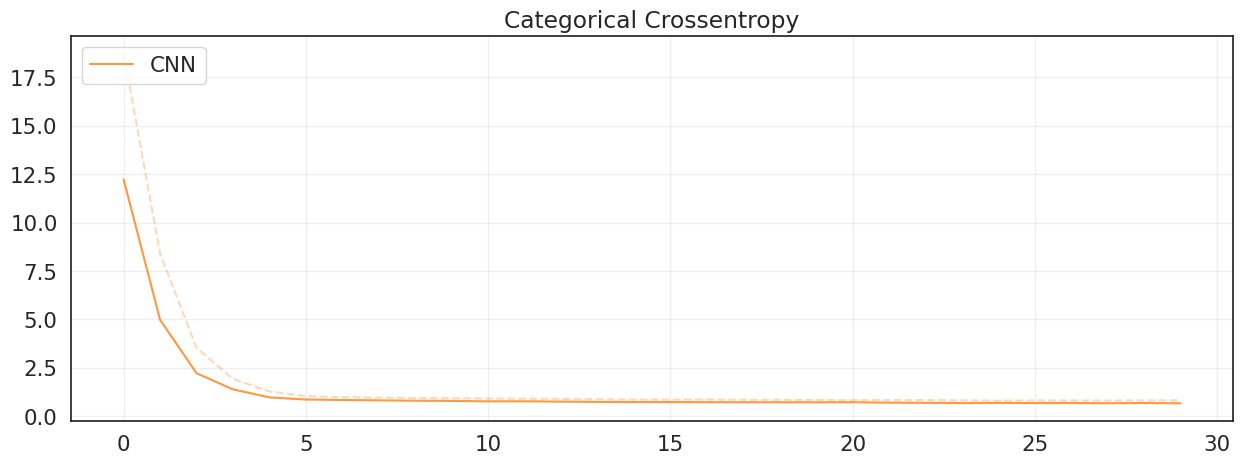

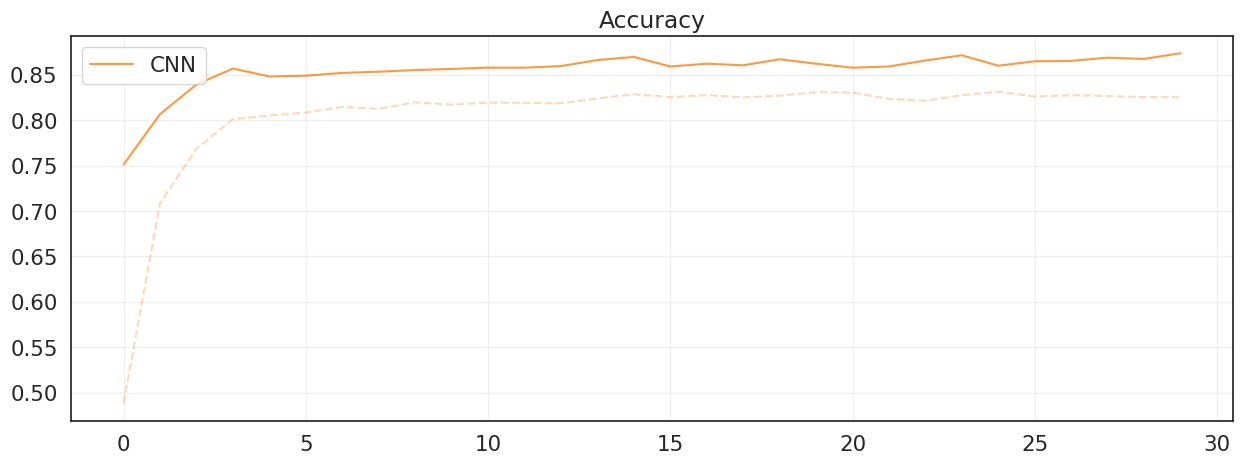

In [26]:
# Plot the training

plt.figure(figsize=(15,5))

plt.plot(history_stage1['loss'], alpha=.3, color='#ff7f0e', linestyle='--')

plt.plot(history_stage1['val_loss'], label='CNN', alpha=.8, color='#ff7f0e')

plt.legend(loc='upper left')

plt.title('Categorical Crossentropy')

plt.grid(alpha=.3)



plt.figure(figsize=(15,5))

plt.plot(history_stage1['accuracy'], alpha=.3, color='#ff7f0e', linestyle='--')

plt.plot(history_stage1['val_accuracy'], label='CNN', alpha=.8, color='#ff7f0e')

plt.legend(loc='upper left')

plt.title('Accuracy')

plt.grid(alpha=.3)

In [27]:
y_prob = model.predict(X_val)
y_pred = y_prob.argmax(axis=1)
y_pred

71/71 ━━━━━━━━━━━━━━━━━━━━ 9s 66ms/step


array([4, 3, 6, ..., 3, 6, 6])

Accuracy: 0.8736
F1 Score: 0.8732

Classification Report:
               precision    recall  f1-score   support

           0     0.7056    0.8580    0.7744       162
           1     0.9390    0.9300    0.9345       414
           2     0.9502    0.8341    0.8884       229
           3     0.8012    0.7649    0.7826       353
           4     0.8561    0.7256    0.7855       164
           5     0.7778    0.7910    0.7843       177
           6     0.9027    0.9344    0.9183       457
           7     0.9371    0.9937    0.9646       315

    accuracy                         0.8736      2271
   macro avg     0.8587    0.8539    0.8541      2271
weighted avg     0.8760    0.8736    0.8732      2271



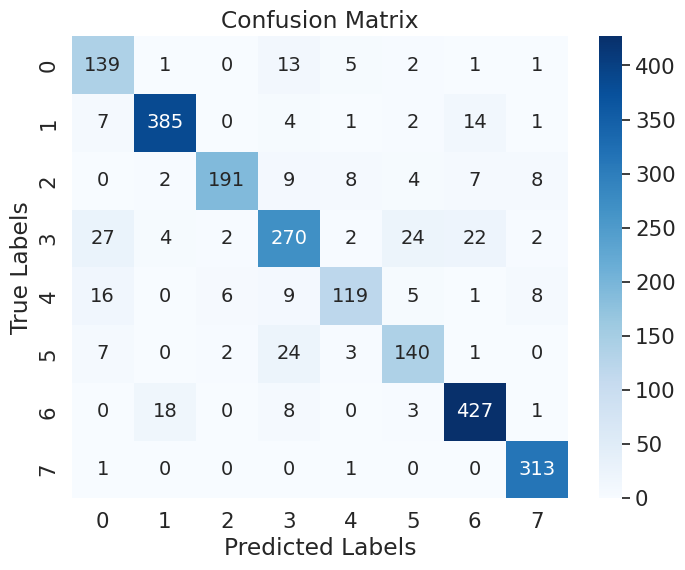

In [28]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, f1_score



# Calculate metrics

accuracy = accuracy_score(y_val, y_pred)

f1 = f1_score(y_val, y_pred, average='weighted')



# Print the results

print(f"Accuracy: {accuracy:.4f}")

print(f"F1 Score: {f1:.4f}")



# Detailed per-class metrics

print("\nClassification Report:\n", classification_report(y_val, y_pred, digits=4))



# Compute confusion matrix

cm = confusion_matrix(y_val, y_pred)



# Create a heatmap for the confusion matrix

plt.figure(figsize=(8, 6))

sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=np.arange(cm.shape[1]), yticklabels=np.arange(cm.shape[0]))

plt.title('Confusion Matrix')

plt.xlabel('Predicted Labels')

plt.ylabel('True Labels')



# Display the plot

plt.show()

In [ ]:
#from tensorflow.keras.models import Model

# Re-load the model after transfer learning

#ft_model = tfk.models.load_model('TL_ResNet50.keras')

# Unfreezing the last 10 layers of the base model (two blocks)

for layer in model.layers[-10:]:

    layer.trainable = True


# Step 2: Recompile the model with a lower learning rate

model.compile(

    loss=tfk.losses.SparseCategoricalCrossentropy(),

    optimizer=tfk.optimizers.Lion(learning_rate=1e-5),  # Lower learning rate for fine-tuning

    metrics=['accuracy']

)

# Display a summary of the model architecture

#ft_model.summary(expand_nested=True)

In [ ]:
# Train the model

history_stage2 = model.fit(

    x=X_train_aug,

    y=y_train,

    batch_size=batch_size,

    epochs=epochs-30,

    class_weight=class_weight_dict,

    validation_data=(X_val, y_val),

    callbacks=[
        tfk.callbacks.EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True),
        tfk.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6)
    ]

).history
# Calculate and print the best validation accuracy achieved

final_val_accuracy = round(max(history_stage2['val_accuracy']) * 100, 2)

print(f'Final validation accuracy: {final_val_accuracy}%')

Epoch 1/70
142/142 ━━━━━━━━━━━━━━━━━━━━ 95s 341ms/step - accuracy: 0.7249 - loss: 1.0636 - val_accuracy: 0.9194 - val_loss: 0.5138 - learning_rate: 1.0000e-05
Epoch 2/70
142/142 ━━━━━━━━━━━━━━━━━━━━ 28s 134ms/step - accuracy: 0.9490 - loss: 0.4000 - val_accuracy: 0.9458 - val_loss: 0.4684 - learning_rate: 1.0000e-05
Epoch 3/70
142/142 ━━━━━━━━━━━━━━━━━━━━ 21s 137ms/step - accuracy: 0.9721 - loss: 0.3120 - val_accuracy: 0.9256 - val_loss: 0.5212 - learning_rate: 1.0000e-05
Epoch 4/70
142/142 ━━━━━━━━━━━━━━━━━━━━ 20s 134ms/step - accuracy: 0.9845 - loss: 0.2473 - val_accuracy: 0.9454 - val_loss: 0.4133 - learning_rate: 1.0000e-05
Epoch 5/70
142/142 ━━━━━━━━━━━━━━━━━━━━ 19s 134ms/step - accuracy: 0.9853 - loss: 0.2049 - val_accuracy: 0.9657 - val_loss: 0.3015 - learning_rate: 1.0000e-05
Epoch 6/70
142/142 ━━━━━━━━━━━━━━━━━━━━ 19s 132ms/step - accuracy: 0.9889 - loss: 0.1758 - val_accuracy: 0.9635 - val_loss: 0.3502 - learning_rate: 1.0000e-05
Epoch 7/70
142/142 ━━━━━━━━━━━━━━━━━━━━ 19s 13

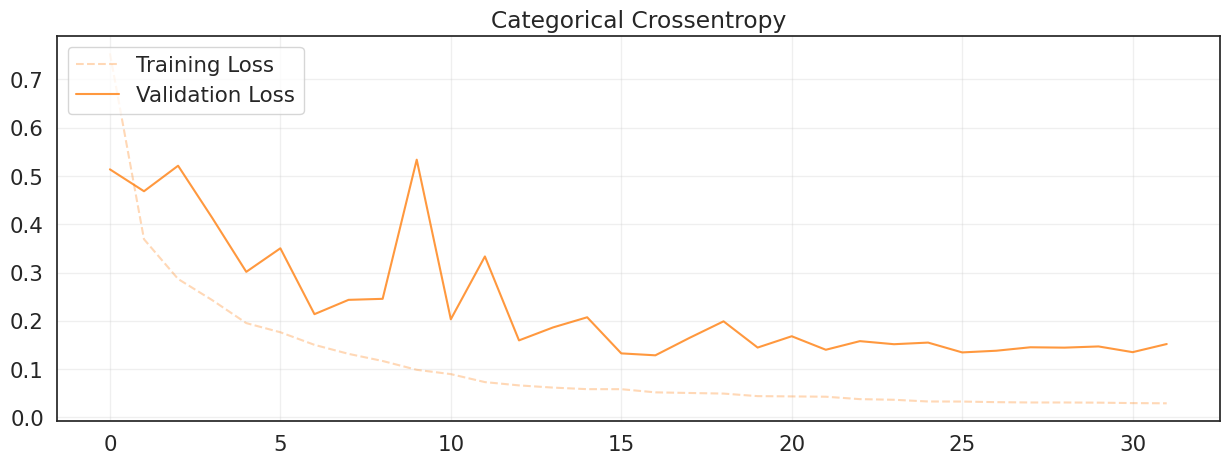

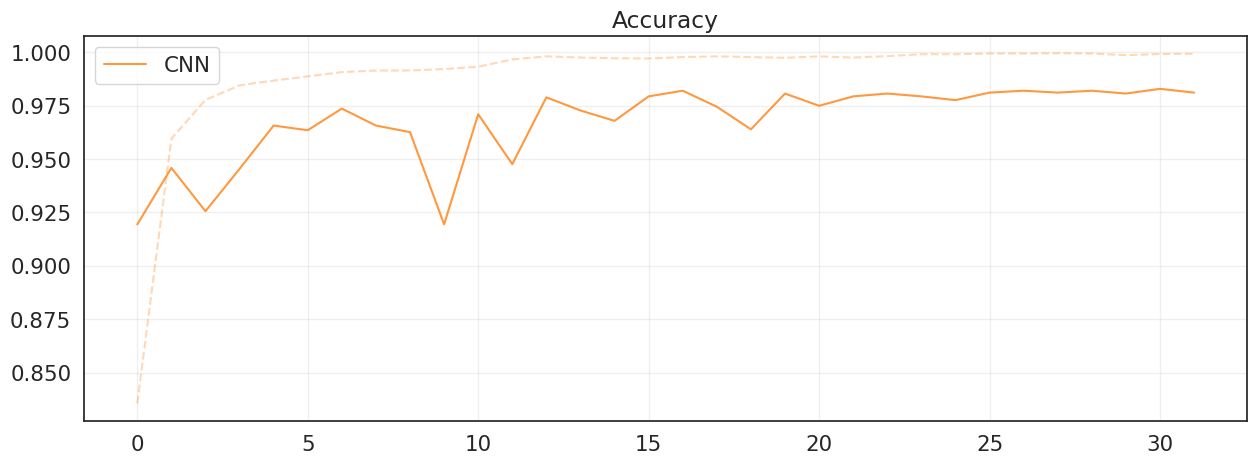

In [ ]:
# Plot the training

plt.figure(figsize=(15,5))

plt.plot(history_stage2['loss'], label='Training Loss',alpha=.3, color='#ff7f0e', linestyle='--')

plt.plot(history_stage2['val_loss'], label='Validation Loss', alpha=.8, color='#ff7f0e')

plt.legend(loc='upper left')

plt.title('Categorical Crossentropy')

plt.grid(alpha=.3)



plt.figure(figsize=(15,5))

plt.plot(history_stage2['accuracy'], alpha=.3, color='#ff7f0e', linestyle='--')

plt.plot(history_stage2['val_accuracy'], label='CNN', alpha=.8, color='#ff7f0e')

plt.legend(loc='upper left')

plt.title('Accuracy')

plt.grid(alpha=.3)

In [ ]:
# Predict probabilities for the test set

y_prob= model.predict(X_val)
y_pred = y_prob.argmax(axis=1)

71/71 ━━━━━━━━━━━━━━━━━━━━ 7s 59ms/step


In [ ]:
# Save model
model.save('weights.keras')

Accuracy: 0.9819
F1 Score: 0.9819

Classification Report:
               precision    recall  f1-score   support

           0     0.9938    0.9938    0.9938       162
           1     1.0000    0.9976    0.9988       414
           2     0.9912    0.9869    0.9891       229
           3     0.9518    0.9518    0.9518       353
           4     0.9878    0.9878    0.9878       164
           5     0.9713    0.9548    0.9630       177
           6     0.9718    0.9803    0.9760       457
           7     0.9968    1.0000    0.9984       315

    accuracy                         0.9819      2271
   macro avg     0.9831    0.9816    0.9823      2271
weighted avg     0.9820    0.9819    0.9819      2271



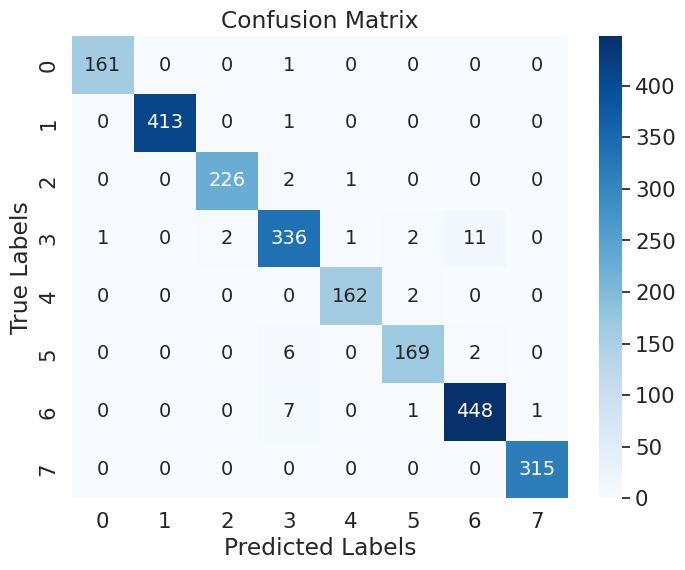

In [ ]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, f1_score



# Calculate metrics

accuracy = accuracy_score(y_val, y_pred)

f1 = f1_score(y_val, y_pred, average='weighted')



# Print the results

print(f"Accuracy: {accuracy:.4f}")

print(f"F1 Score: {f1:.4f}")



# Detailed per-class metrics

print("\nClassification Report:\n", classification_report(y_val, y_pred, digits = 4))



# Compute confusion matrix

cm = confusion_matrix(y_val, y_pred)



# Create a heatmap for the confusion matrix

plt.figure(figsize=(8, 6))

sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=np.arange(cm.shape[1]), yticklabels=np.arange(cm.shape[0]))

plt.title('Confusion Matrix')

plt.xlabel('Predicted Labels')

plt.ylabel('True Labels')



# Display the plot

plt.show()

In [ ]:
%%writefile model.py

import numpy as np



import tensorflow as tf

from tensorflow import keras as tfk

from tensorflow.keras import layers as tfkl





class Model:

    def __init__(self):

        """

        Initialize the internal state of the model. Note that the __init__

        method cannot accept any arguments.



        The following is an example loading the weights of a pre-trained

        model.

        """

        self.neural_network = tfk.models.load_model('weights.keras')



    def predict(self, X):

        """

        Predict the labels corresponding to the input X. Note that X is a numpy

        array of shape (n_samples, 96, 96, 3) and the output should be a numpy

        array of shape (n_samples,). Therefore, outputs must no be one-hot

        encoded.



        The following is an example of a prediction from the pre-trained model

        loaded in the __init__ method.

        """

        preds = self.neural_network.predict(X)

        if len(preds.shape) == 2:

            preds = np.argmax(preds, axis=1)

        return preds

Overwriting model.py


In [ ]:
from datetime import datetime
filename = f'submission_{datetime.now().strftime("%y%m%d_%H%M%S")}.zip'

# Add files to the zip command if needed
!zip {filename} model.py weights.keras

from google.colab import files
files.download(filename)

  adding: model.py (deflated 57%)
  adding: weights.keras (deflated 7%)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>